<a href="https://colab.research.google.com/github/vektor8891/llm/blob/main/projects/19_lora_pytorch/19_lora_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install torchtext==0.17.2
# !pip install portalocker==2.8.2
# !pip install torchdata==0.7.1
# !pip install numpy==1.26.0

# LoRA with PyTorch

- Low-Rank Adaptation (LoRA): fine-tune model by introducing small fraction of additional parameters compared to the total number of parameters in a large model

### Defining helper functions

In [2]:
import matplotlib.pyplot as plt


def plot(COST,ACC):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # You already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()

In [3]:
import pickle

def save_list_to_file(lst, filename):
    """
    Save a list to a file using pickle serialization.

    Parameters:
        lst (list): The list to be saved.
        filename (str): The name of the file to save the list to.

    Returns:
        None
    """
    with open(filename, 'wb') as file:
        pickle.dump(lst, file)

def load_list_from_file(filename):
    """
    Load a list from a file using pickle deserialization.

    Parameters:
        filename (str): The name of the file to load the list from.

    Returns:
        list: The loaded list.
    """
    with open(filename, 'rb') as file:
        loaded_list = pickle.load(file)
    return loaded_list

## Data pipeline

In [4]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for  _,text in data_iter:
        yield tokenizer(text)

In [5]:
from torchtext.vocab import GloVe, Vectors

# Note that GloVe embeddings are typically downloaded using:
#glove_embedding = GloVe(name="6B", dim=100)
# However, the GloVe server is frequently down. The code below offers a workaround

class GloVe_override(Vectors):
    url = {
        "6B": "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/tQdezXocAJMBMPfUJx_iUg/glove-6B.zip",
    }

    def __init__(self, name="6B", dim=100, **kwargs) -> None:
        url = self.url[name]
        name = "glove.{}.{}d.txt".format(name, str(dim))
        #name = "glove.{}/glove.{}.{}d.txt".format(name, name, str(dim))
        super(GloVe_override, self).__init__(name, url=url, **kwargs)

class GloVe_override2(Vectors):
    url = {
        "6B": "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/tQdezXocAJMBMPfUJx_iUg/glove-6B.zip",
    }

    def __init__(self, name="6B", dim=100, **kwargs) -> None:
        url = self.url[name]
        #name = "glove.{}.{}d.txt".format(name, str(dim))
        name = "glove.{}/glove.{}.{}d.txt".format(name, name, str(dim))
        super(GloVe_override2, self).__init__(name, url=url, **kwargs)

try:
    glove_embedding = GloVe_override(name="6B", dim=100)
except:
    try:
        glove_embedding = GloVe_override2(name="6B", dim=100)
    except:
        glove_embedding = GloVe(name="6B", dim=100)

In [6]:
from torchtext.vocab import vocab

vocab = vocab(glove_embedding .stoi, 0,specials=('<unk>', '<pad>'))
vocab.set_default_index(vocab["<unk>"])

def text_pipeline(x):
  return vocab(tokenizer(x))

def label_pipeline(x):
   return int(x)

## IMDB dataset

In [7]:
from urllib.request import urlopen
import tarfile
import tempfile
import io

urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/35t-FeC-2uN1ozOwPs7wFg.gz')
tar = tarfile.open(fileobj=io.BytesIO(urlopened.read()))
tempdir = tempfile.TemporaryDirectory()
tar.extractall(tempdir.name)
tar.close()

In [8]:
from torch.utils.data.dataset import Dataset


class IMDBDataset(Dataset):
    def __init__(self, root_dir, train=True):
        """
        root_dir: The base directory of the IMDB dataset.
        train: A boolean flag indicating whether to use training or test data.
        """
        self.root_dir = os.path.join(root_dir, "train" if train else "test")
        self.neg_files = [os.path.join(self.root_dir, "neg", f) for f in os.listdir(os.path.join(self.root_dir, "neg")) if f.endswith('.txt')]
        self.pos_files = [os.path.join(self.root_dir, "pos", f) for f in os.listdir(os.path.join(self.root_dir, "pos")) if f.endswith('.txt')]
        self.files = self.neg_files + self.pos_files
        self.labels = [0] * len(self.neg_files) + [1] * len(self.pos_files)
        self.pos_inx=len(self.pos_files)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        label = self.labels[idx]
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()

        return label, content

In [9]:
import os

root_dir = tempdir.name + '/' + 'imdb_dataset'
train_iter = IMDBDataset(root_dir=root_dir, train=True)  # For training data
test_iter = IMDBDataset(root_dir=root_dir, train=False)  # For test dataart=train_iter.pos_inx

In [10]:
start=train_iter.pos_inx
start=0
for i in range(-10,10):
    print(train_iter[start+i])

(1, "A bunch of American students and their tutor decide to visit the ugliest part of Ireland in order to study ancient religious practices. Despite being repeatedly warned about the dangers of straying off the beaten path (by the local creepy Irish guy, natch), they do just that, and wind up with their insides on the outside courtesy of a family of inbred cannibals (the descendants of the infamous Sawney Bean clan, who according to the film's silly plot, upped sticks from Scotland and settled on the Emerald Isle).<br /><br />If you think that porn stars plus low budget horror automatically equals tons of nudity and terrible acting, then think again: Evil Breed is bristling with adult stars, but in fact, there's not nearly as much nudity as one might expect given the 'talent' involved, and the acting, although far from Oscar worthy, ain't all that bad (with the exception of Ginger Lynn Allen, who we know can do marvellous 'French', but whose Irish is lousy).<br /><br />Evil Breed opens

In [11]:
imdb_label = {0: " negative review", 1: "positive review"}
imdb_label[1]

'positive review'

In [12]:
num_class = len(set([label for (label, text) in train_iter ]))
num_class

2

In [13]:
vocab(["age","hello"])

[466, 13077]

### Train and validate

In [14]:
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data.dataset import random_split,Dataset

# Convert the training and testing iterators to map-style datasets.
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# Determine the number of samples to be used for training and validation (5% for validation).
num_train = int(len(train_dataset) * 0.95)

# Randomly split the training dataset into training and validation datasets using `random_split`.
# The training dataset will contain 95% of the samples, and the validation dataset will contain the remaining 5%.
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

In [15]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Data loader

In [16]:
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    label_list, text_list = [], []
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        text_list.append(torch.tensor(text_pipeline(_text), dtype=torch.int64))


    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = pad_sequence(text_list, batch_first=True)


    return label_list.to(device), text_list.to(device)

In [17]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

In [18]:
label,seqence=next(iter(valid_dataloader ))
label,seqence

(tensor([1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
         0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
         1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]),
 tensor([[   43,    59,  1970,  ...,     0,     0,     0],
         [   22,    59,  1536,  ...,     0,     0,     0],
         [  104,     9,  2907,  ...,     0,     0,     0],
         ...,
         [    2, 37662,    16,  ...,     0,     0,     0],
         [  378,    43,   915,  ...,     0,     0,     0],
         [   43,    88,   255,  ...,     0,     0,     0]]))

### Neural network

In [19]:
from torch import nn

class TextClassifier(nn.Module):
    def __init__(self, num_classes,freeze=False):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(glove_embedding.vectors.to(device),freeze=freeze)
        # An example of adding additional layers: A linear layer and a ReLU activation
        self.fc1 = nn.Linear(in_features=100, out_features=128)
        self.relu = nn.ReLU()
        # The output layer that gives the final probabilities for the classes
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, x):
        # Pass the input through the embedding layer
        x = self.embedding(x)
        # Here you can use a simple mean pooling

        x = torch.mean(x, dim=1)
        # Pass the pooled embeddings through the additional layers
        x = self.fc1(x)
        x = self.relu(x)
        return self.fc2(x)

## Train the model on the full dataset

In [20]:
model=TextClassifier(num_classes=2,freeze=True)
model.to(device)

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [21]:
model.eval()
predicted_label=model(seqence)

In [22]:
print(predicted_label.shape)

torch.Size([64, 2])


In [23]:
predicted_label

tensor([[-0.2465, -0.0452],
        [-0.2272, -0.0255],
        [-0.2469, -0.0477],
        [-0.2533, -0.0551],
        [-0.2351, -0.0313],
        [-0.2532, -0.0559],
        [-0.2453, -0.0466],
        [-0.2462, -0.0435],
        [-0.2503, -0.0519],
        [-0.2481, -0.0480],
        [-0.2424, -0.0382],
        [-0.2495, -0.0518],
        [-0.1851,  0.0347],
        [-0.2226, -0.0110],
        [-0.2441, -0.0452],
        [-0.2216, -0.0122],
        [-0.2488, -0.0482],
        [-0.2442, -0.0447],
        [-0.2453, -0.0497],
        [-0.2549, -0.0581],
        [-0.2512, -0.0549],
        [-0.2385, -0.0385],
        [-0.2326, -0.0329],
        [-0.2319, -0.0272],
        [-0.2520, -0.0557],
        [-0.2448, -0.0404],
        [-0.2476, -0.0534],
        [-0.2493, -0.0494],
        [-0.2540, -0.0570],
        [-0.2584, -0.0618],
        [-0.2443, -0.0483],
        [-0.2412, -0.0377],
        [-0.2461, -0.0470],
        [-0.2414, -0.0439],
        [-0.2299, -0.0242],
        [-0.2490, -0

In [24]:
def predict(text, model, text_pipeline):
    with torch.no_grad():
        text = torch.unsqueeze(torch.tensor(text_pipeline(text)),0).to(device)

        output = model(text)
        return imdb_label[output.argmax(1).item()]

In [25]:
predict("the is a good movie",model,text_pipeline )

'positive review'

In [26]:
def evaluate(dataloader, model, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for label, text in dataloader:
            label, text = label.to(device), text.to(device)
            outputs = model(text)
            _, predicted = torch.max(outputs.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [27]:
evaluate(test_dataloader , model, device)

50.0

## Train the model

In [28]:
from tqdm import tqdm

def train_model(model, optimizer, criterion, train_dataloader, valid_dataloader, epochs=100, model_name="my_modeldrop"):
    cum_loss_list = []
    acc_epoch = []
    best_acc = 0
    file_name = model_name

    for epoch in tqdm(range(1, epochs + 1)):
        model.train()
        cum_loss = 0
        for _, (label, text) in enumerate(train_dataloader):
            optimizer.zero_grad()
            predicted_label = model(text)
            loss = criterion(predicted_label, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()
            cum_loss += loss.item()
        #print("Loss:", cum_loss)
        cum_loss_list.append(cum_loss)
        acc_val = evaluate(valid_dataloader, model, device)
        acc_epoch.append(acc_val)

        if acc_val > best_acc:
            best_acc = acc_val
            print(f"New best accuracy: {acc_val:.4f}")
            #torch.save(model.state_dict(), f"{model_name}.pth")

    #save_list_to_file(cum_loss_list, f"{model_name}_loss.pkl")
    #save_list_to_file(acc_epoch, f"{model_name}_acc.pkl")

In [29]:
LR=1

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

In [30]:
model_name="model_imdb_freeze_true2"
train_model(model, optimizer, criterion, train_dataloader, valid_dataloader, epochs=2, model_name=model_name)

 50%|█████     | 1/2 [00:13<00:13, 13.36s/it]

New best accuracy: 52.6400


100%|██████████| 2/2 [00:25<00:00, 12.54s/it]


In [31]:
# load pretrained model

%%capture
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/ZvhVWJU0flC7BmU1jjYxjg/model-imdb-freeze-true2.pth
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/2RdN-JG4Rm5Gx3UNtOP4NA/model-imdb-freeze-true2-acc.pkl
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/8qoGvWk0BdXRGoFAOT-dAw/model-imdb-freeze-true2-loss.pkl

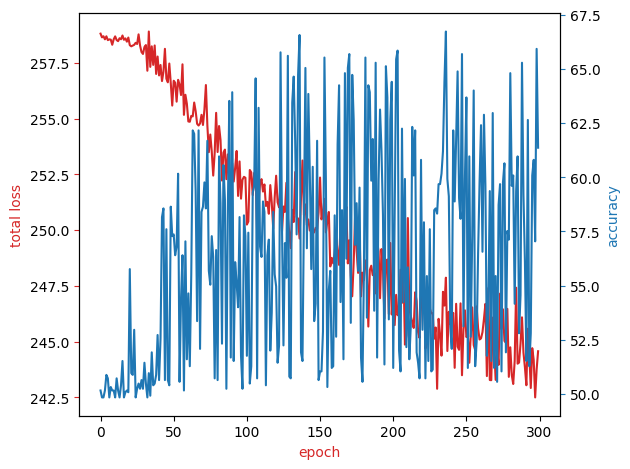

In [32]:
cum_loss_list=load_list_from_file(model_name.replace('_','-') + "-loss.pkl")
acc_epoch=load_list_from_file(model_name.replace('_','-') + "-acc.pkl")
plot(cum_loss_list,acc_epoch)

In [33]:
model.load_state_dict(torch.load(model_name.replace('_','-') + ".pth", map_location=device))
model.eval()

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

##  Low-Rank Adaptation (LoRA)

### Rank

In [34]:
from sympy import init_printing

init_printing()

In [35]:
def plot_matrix_and_subspace(F):
    assert F.shape[0] == 3, "Matrix F must have rows equal to 3 for 3D visualization."

    ax = plt.figure().add_subplot(projection='3d')

    # Plot each column vector of F as a point and line from the origin
    for i in range(F.shape[1]):
        ax.quiver(0, 0, 0, F[0, i], F[1, i], F[2, i], color='blue', arrow_length_ratio=0.1, label=f'Column {i+1}')

    if F.shape[1] == 2:
        # Calculate the normal to the plane spanned by the columns of F if they are exactly two
        normal_vector = np.cross(F[:, 0], F[:, 1])
        # Plot the plane
        xx, yy = np.meshgrid(np.linspace(-3, 3, 10), np.linspace(-3, 3, 10))
        zz = (-normal_vector[0] * xx - normal_vector[1] * yy) / normal_vector[2] if normal_vector[2] != 0 else 0
        ax.plot_surface(xx, yy, zz, alpha=0.5, color='green', label='Spanned Plane')

    # Set plot limits and labels
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_zlim([-3, 3])
    ax.set_xlabel('$x_{1}$')
    ax.set_ylabel('$x_{2}$')
    ax.set_zlabel('$x_{3}$')
    #ax.legend()

    plt.show()

In [40]:
from scipy.linalg import null_space

def plot_matrix_and_subspace(F):
    assert F.shape[0] == 3, "Matrix F must have 3 rows to represent 3D space."

    ax = plt.figure().add_subplot(projection='3d')

    # Plot each column vector of F
    for i in range(F.shape[1]):
        ax.quiver(0, 0, 0, F[0, i], F[1, i], F[2, i], color='blue', arrow_length_ratio=0.1, label=f'Column {i+1}')

    # Calculate the null space of the transpose of F
    normal_vector = null_space(F.T)

    # Check that the null space is 1-dimensional
    if normal_vector.shape[1] == 1:
        normal_vector = normal_vector[:, 0]  # Simplify the array to 1D
        # Create a meshgrid for the plane
        xx, yy = np.meshgrid(np.linspace(-3, 3, 10), np.linspace(-3, 3, 10))
        # Calculate corresponding z coordinates based on the plane equation ax + by + cz = 0
        zz = (-normal_vector[0] * xx - normal_vector[1] * yy) / normal_vector[2] if normal_vector[2] != 0 else 0
        ax.plot_surface(xx, yy, zz, alpha=0.5, color='green', label='Spanned Plane')
    else:
        print("The null space is not 1-dimensional, so a unique plane cannot be determined.")

    # Set plot limits and labels
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_zlim([-3, 3])
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    #ax.legend()

    plt.show()

In [41]:
import numpy as np
from sympy import Matrix

B=torch.tensor([[1,0],[0,1],[0,0]]).numpy()

Matrix(B)

⎡1  0⎤
⎢    ⎥
⎢0  1⎥
⎢    ⎥
⎣0  0⎦

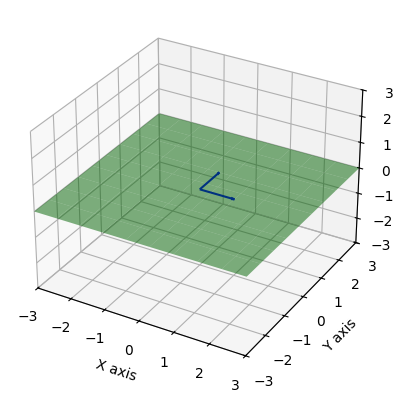

In [42]:
plot_matrix_and_subspace(B)

In [44]:
from numpy.linalg import matrix_rank

matrix_rank(B)

2

In [45]:
A=torch.tensor([[1,1,-1,1,0],[-2,2,2,0,1]]).numpy()
Matrix(A)

⎡1   1  -1  1  0⎤
⎢               ⎥
⎣-2  2  2   0  1⎦

In [46]:
matrix_rank(A)

2

In [47]:
C=B@A
Matrix(C)

⎡1   1  -1  1  0⎤
⎢               ⎥
⎢-2  2  2   0  1⎥
⎢               ⎥
⎣0   0  0   0  0⎦

rank of C 2


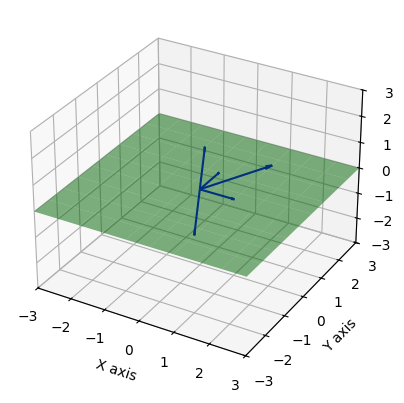

In [48]:
print("rank of C",matrix_rank(C))
plot_matrix_and_subspace(C)

### Understanding LoRA in PyTorch

In [49]:
class LoRALayer(torch.nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        std_dev = 1 / torch.sqrt(torch.tensor(rank).float())
        self.A = torch.nn.Parameter(torch.randn(in_dim, rank) * std_dev)

        self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha

    def forward(self, x):
        x = self.alpha * (x @ self.A @ self.B)
        return x

In [50]:
class LinearWithLoRA(torch.nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear.to(device)
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        ).to(device)

    def forward(self, x):

        return self.linear(x) + self.lora(x)

### Applying LoRA

In [65]:
model_lora=TextClassifier(num_classes=4,freeze=False)
model_lora.to(device)

urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/uGC04Pom651hQs1XrZ0NsQ/my-model-freeze-false.pth')

stream = io.BytesIO(urlopened.read())
state_dict = torch.load(stream, map_location=device)
model_lora.load_state_dict(state_dict)

# Here, you freeze all layers:
for parm in model_lora.parameters():
    parm.requires_grad=False
model_lora

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

In [66]:
model_lora.fc2=nn.Linear(in_features=128, out_features=2, bias=True).to(device)
model_lora

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [76]:
# access hidden layer
model_lora.fc1

Linear(in_features=100, out_features=128, bias=True)

In [77]:
# replace layer with LoRA
model_lora.fc1=LinearWithLoRA(model_lora.fc1,rank=2, alpha=0.1).to(device)

In [78]:
model_lora.fc1

LinearWithLoRA(
  (linear): Linear(in_features=100, out_features=128, bias=True)
  (lora): LoRALayer()
)

In [79]:
model_lora.to(device)

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): LinearWithLoRA(
    (linear): Linear(in_features=100, out_features=128, bias=True)
    (lora): LoRALayer()
  )
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [80]:
# code to select the values for  `r` and `alpha`
# ranks = [1, 2, 5, 10]
# alphas = [0.1, 0.5, 1.0, 2.0, 5.0]

# results=[]
# accuracy_old=0
# # Loop over each combination of 'r' and 'alpha'
# for r in ranks:
#     for alpha in alphas:
#         print(f"Testing with rank = {r} and alpha = {alpha}")
#         model_name=f"model_lora_rank{r}_alpha{alpha}_AGtoIBDM_final_adam_"

#         model_lora=TextClassifier(num_classes=4,freeze=False)
#         model_lora.to(device)

#         urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/uGC04Pom651hQs1XrZ0NsQ/my-model-freeze-false.pth')

#         stream = io.BytesIO(urlopened.read())
#         state_dict = torch.load(stream, map_location=device)
#         model_lora.load_state_dict(state_dict)

#         for parm in model_lora.parameters():
#             parm.requires_grad=False

#         model_lora.fc2=nn.Linear(in_features=128, out_features=2, bias=True)
#         model_lora.fc1=LinearWithLoRA(model_lora.fc1,rank=r, alpha=alpha )
#         optimizer = torch.optim.Adam(model_lora.parameters(), lr=LR)

#         scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)

#         model_lora.to(device)


#         train_model(model_lora, optimizer, criterion, train_dataloader, valid_dataloader, epochs=300, model_name=model_name)

#         accuracy=evaluate(valid_dataloader ,  model_lora, device)
#         result = {
#             'rank': r,
#             'alpha': alpha,
#             'accuracy':accuracy
#         }

#         # Append the dictionary to the results list
#         results.append(result)

In [81]:
LR=1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_lora.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

In [82]:
model_name="model_lora_final2"
train_model(model_lora,optimizer, criterion, train_dataloader, valid_dataloader, epochs=2, model_name=model_name)

 50%|█████     | 1/2 [00:12<00:12, 12.29s/it]

New best accuracy: 57.3600


100%|██████████| 2/2 [00:24<00:00, 12.23s/it]

New best accuracy: 60.2400


In [83]:
%%capture
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/JWPRb1RMhKLRMUWOKw9pxA/model-lora-final2.pth
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/_dm02rLyTrwsXEQh2r32sQ/model-lora-final2-acc.pkl
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/OZbVqKjoqOSIwnET8AB1KA/model-lora-final2-loss.pkl

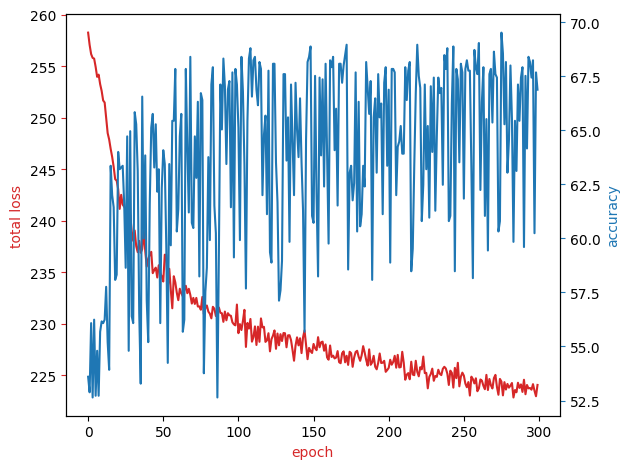

In [84]:
cum_loss_list=load_list_from_file(model_name.replace('_','-') + "-loss.pkl")
acc_epoch=load_list_from_file(model_name.replace('_','-') + "-acc.pkl")
plot(cum_loss_list,acc_epoch)

In [86]:
model_lora.load_state_dict(torch.load(model_name.replace('_','-') + ".pth", map_location=device))
model_lora.eval()

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): LinearWithLoRA(
    (linear): Linear(in_features=100, out_features=128, bias=True)
    (lora): LoRALayer()
  )
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [87]:
evaluate(test_dataloader , model_lora, device)

69.112

In [88]:
model_lora.fc1

LinearWithLoRA(
  (linear): Linear(in_features=100, out_features=128, bias=True)
  (lora): LoRALayer()
)

In [92]:
B=model_lora.fc1.lora.B
print("B",B)
print("\n Number of elements in the tensor B",B.numel())
torch.save(B, 'B.pth')

B Parameter containing:
tensor([[-4.3192e-01, -1.1071e+00,  2.4456e-01, -3.1031e-02, -2.0012e-01,
         -6.7811e-01, -1.3552e-01, -2.7458e-01,  3.2278e-02,  6.7592e-02,
          8.3020e-01,  1.1610e-05, -1.0894e-01,  7.7830e-05, -1.6789e-01,
         -1.3309e-01, -5.1875e-01,  2.1928e-02, -6.5869e-02, -3.5834e-01,
         -2.4473e-02, -1.1260e+00, -8.8752e-02, -7.0861e-03, -1.3263e-02,
          0.0000e+00, -6.9039e-01, -8.6471e-02, -3.9146e-01, -2.2644e-01,
         -8.7611e-01, -7.9929e-01,  0.0000e+00,  3.9646e-01,  5.2164e-01,
         -4.2730e-01,  2.3550e-01,  4.0447e-02,  2.3289e-01, -4.5217e-01,
          1.7721e-03, -4.7263e-01, -2.4343e-01,  6.3737e-01,  0.0000e+00,
          2.6904e-03, -7.8828e-01,  2.2559e-02, -4.3776e-02,  3.0909e-01,
         -1.6914e-01, -2.0294e-01, -4.2175e-01,  7.8840e-01, -3.1771e-01,
         -2.0639e-01,  1.1487e-02, -5.7238e-01,  1.4071e-01, -2.8561e-01,
          1.1753e-01, -1.6501e-04, -4.5406e-01,  0.0000e+00,  6.4464e-05,
         -4.45

In [93]:
A=model_lora.fc1.lora.A
print("A",A)
print("\n Number of elements in the tensor A",A.numel())
torch.save(A, 'A.pth')

A Parameter containing:
tensor([[ 3.2952e-01,  9.3019e-01],
        [ 2.3904e+00, -5.1022e+00],
        [-2.4573e-01,  2.4733e+00],
        [ 5.8014e-01,  3.9014e-01],
        [ 1.6970e+00, -2.4614e+00],
        [-1.2420e+00,  8.3014e-01],
        [-2.0468e+00,  1.1629e+00],
        [-5.9361e-01,  1.8099e-01],
        [ 9.2466e-02,  1.1583e-01],
        [-2.0841e-02,  1.5550e+00],
        [ 1.3028e+00, -9.8381e-01],
        [ 1.4320e+00, -3.3497e+00],
        [-1.1637e+00,  1.9436e+00],
        [ 2.4898e-01, -1.1353e+00],
        [ 2.4423e+00,  1.0154e+00],
        [ 2.4881e+00, -4.6765e+00],
        [-1.8985e-01,  1.3426e+00],
        [-1.1730e-01, -2.1925e+00],
        [ 2.0193e+00, -8.5886e-01],
        [-3.1268e+00,  3.5134e+00],
        [ 1.0935e+00, -2.9263e+00],
        [-1.0435e+00,  2.5428e-01],
        [-8.6704e-01,  2.3570e+00],
        [-5.2725e-02, -2.3731e-01],
        [-4.3896e+00,  5.0369e+00],
        [-1.1174e+00,  9.9728e-01],
        [ 4.7710e-01, -1.2162e+00],
    

In [94]:
print("\n Number of elements in the tensor A",model_lora.fc1.linear.weight.numel())


 Number of elements in the tensor A 12800


In [95]:
alfa_=model_lora.fc1.lora.alpha
torch.save(alfa_, 'alfa_.pth')
torch.save(model_lora.fc2.state_dict(), 'out_layer.pth')

## Loading the model

Main advantage of LoRA: for fine-tuning, only need to save:
- learnable parameters A and B
- alpha
- output layer

In [96]:
A = torch.load('A.pth')
print("A:",A.shape)

A: torch.Size([100, 2])


In [97]:
B = torch.load('B.pth')
print("B:",B.shape)

B: torch.Size([2, 128])


In [99]:
alfa_ = torch.load('alfa_.pth')
alfa_

0.1

In [100]:
output_layer=nn.Linear(in_features=128, out_features=2, bias=True)
output_layer.load_state_dict(torch.load('out_layer.pth'))

<All keys matched successfully>

In [101]:
model_load_lora = TextClassifier(num_classes=4,freeze=False)
model_load_lora.to(device)

urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/uGC04Pom651hQs1XrZ0NsQ/my-model-freeze-false.pth')

stream = io.BytesIO(urlopened.read())
state_dict = torch.load(stream, map_location=device)
model_load_lora.load_state_dict(state_dict)

model_load_lora

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

In [102]:
model_load_lora.fc1=LinearWithLoRA(model_load_lora.fc1,rank=2, alpha=0.1)
model_load_lora.fc2=nn.Linear(in_features=128, out_features=2, bias=True).to(device)

In [103]:
model_load_lora.fc1.lora.A=A
model_load_lora.fc1.lora.B=B
model_load_lora.fc1.lora.alpha=alfa_
model_load_lora.fc2=output_layer

In [105]:
model_load_lora.to(device)
model_load_lora.eval()

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): LinearWithLoRA(
    (linear): Linear(in_features=100, out_features=128, bias=True)
    (lora): LoRALayer()
  )
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [106]:
evaluate(test_dataloader , model_load_lora, device)

69.204

In [107]:
article="""This was a lacklustre movie with very little going for it. I was not impressed."""

In [109]:
from IPython.display import Markdown as md

result = predict(article, model_load_lora, text_pipeline)

markdown_content = f'''
<div style="background-color: lightgray; padding: 10px;">
    <h3>{article}</h3>
    <h4>The category of the news article: {result}</h4>
</div>
'''

md(markdown_content)


<div style="background-color: lightgray; padding: 10px;">
    <h3>This was a lacklustre movie with very little going for it. I was not impressed.</h3>
    <h4>The category of the news article:  negative review</h4>
</div>


## Exercise: Apply LoRA to a different network

In [112]:
import torch.nn.functional as F

class NNet(nn.Module):

    def __init__(self):
        super(NNet, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, input):
        # Convolution layer C1: 1 input image channel, 6 output channels,
        # 5x5 square convolution, it uses RELU activation function, and
        # outputs a Tensor with size (N, 6, 28, 28), where N is the size of the batch
        c1 = F.relu(self.conv1(input))
        # Subsampling layer S2: 2x2 grid, purely functional,
        # this layer does not have any parameter, and outputs a (N, 6, 14, 14) Tensor
        s2 = F.max_pool2d(c1, (2, 2))
        # Convolution layer C3: 6 input channels, 16 output channels,
        # 5x5 square convolution, it uses RELU activation function, and
        # outputs a (N, 16, 10, 10) Tensor
        c3 = F.relu(self.conv2(s2))
        # Subsampling layer S4: 2x2 grid, purely functional,
        # this layer does not have any parameter, and outputs a (N, 16, 5, 5) Tensor
        s4 = F.max_pool2d(c3, 2)
        # Flatten operation: purely functional, outputs a (N, 400) Tensor
        s4 = torch.flatten(s4, 1)
        # Fully connected layer F5: (N, 400) Tensor input,
        # and outputs a (N, 120) Tensor, it uses RELU activation function
        f5 = F.relu(self.fc1(s4))
        # Fully connected layer F6: (N, 120) Tensor input,
        # and outputs a (N, 84) Tensor, it uses RELU activation function
        f6 = F.relu(self.fc2(f5))
        # Gaussian layer OUTPUT: (N, 84) Tensor input, and
        # outputs a (N, 10) Tensor
        output = self.fc3(f6)
        return output

model_exercise = NNet()
model_exercise.to(device)

print('This is what the model looked like before applying LoRA:')
print(model_exercise)
print("\n###############\n")

# Freeze all parameters:
for parm in model_exercise.parameters():
    parm.requires_grad=False

# Change final layer for one with 26 outputs:
model_exercise.fc3=nn.Linear(in_features=84, out_features=26, bias=True).to(device)

# Apply LoRA to the second linear layer
model_exercise.fc2=LinearWithLoRA(model_exercise.fc2,rank=2, alpha=0.1).to(device)

print('This is what the model looked like after applying LoRA:')
print(model_exercise)

This is what the model looked like before applying LoRA:
NNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

###############

This is what the model looked like after applying LoRA:
NNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): LinearWithLoRA(
    (linear): Linear(in_features=120, out_features=84, bias=True)
    (lora): LoRALayer()
  )
  (fc3): Linear(in_features=84, out_features=26, bias=True)
)


In [113]:
!pip freeze > requirements.txt